# Библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import random_split, Subset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tensorflow.keras.layers import Input
import cv2
import pandas as pd
import os

2025-04-30 16:43:32.567072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 16:43:38.258491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Анализ данных

Кол-во изображений:  9510
Кол-во классов:  100
Размер изображений: torch.Size([3, 32, 32])


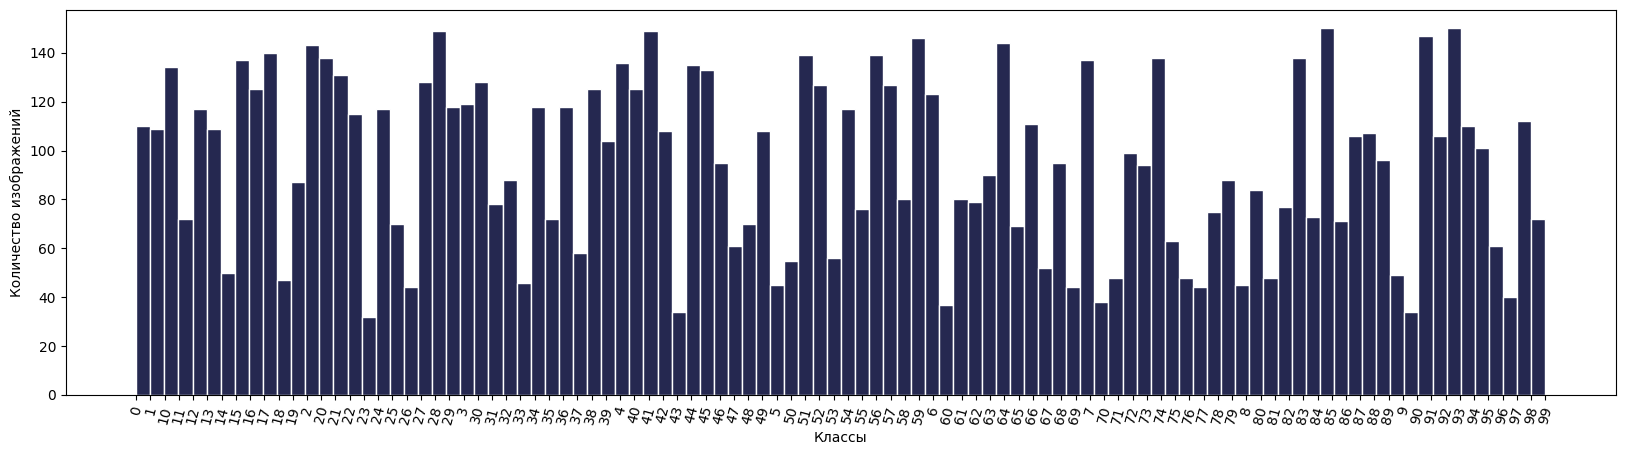

In [2]:
dataset = datasets.ImageFolder(root="data/train", transform=transforms.ToTensor())

print('Кол-во изображений: ', len(dataset))
print('Кол-во классов: ', len(dataset.classes))

dataset.classes = np.array(dataset.classes, dtype=int)
image, _ = dataset[0]
print('Размер изображений:', image.shape)
y_TRUE = [y_true for _, y_true in dataset]

plt.figure(figsize=(20, 5))
plt.hist(y_TRUE, bins=len(dataset.classes), edgecolor='w', color='#252850')
plt.xticks(ticks=range(0, 100), labels=dataset.classes, rotation=75)
plt.xlabel('Классы')
plt.ylabel('Количество изображений');

In [3]:
_, count = np.unique(y_TRUE,return_counts=True)
count

array([110, 109, 134,  72, 117, 109,  50, 137, 125, 140,  47,  87, 143,
       138, 131, 115,  32, 117,  70,  44, 128, 149, 118, 119, 128,  78,
        88,  46, 118,  72, 118,  58, 125, 104, 136, 125, 149, 108,  34,
       135, 133,  95,  61,  70, 108,  45,  55, 139, 127,  56, 117,  76,
       139, 127,  80, 146, 123,  37,  80,  79,  90, 144,  69, 111,  52,
        95,  44, 137,  38,  48,  99,  94, 138,  63,  48,  44,  75,  88,
        45,  84,  48,  77, 138,  73, 150,  71, 106, 107,  96,  49,  34,
       147, 106, 150, 110, 101,  61,  40, 112,  72])

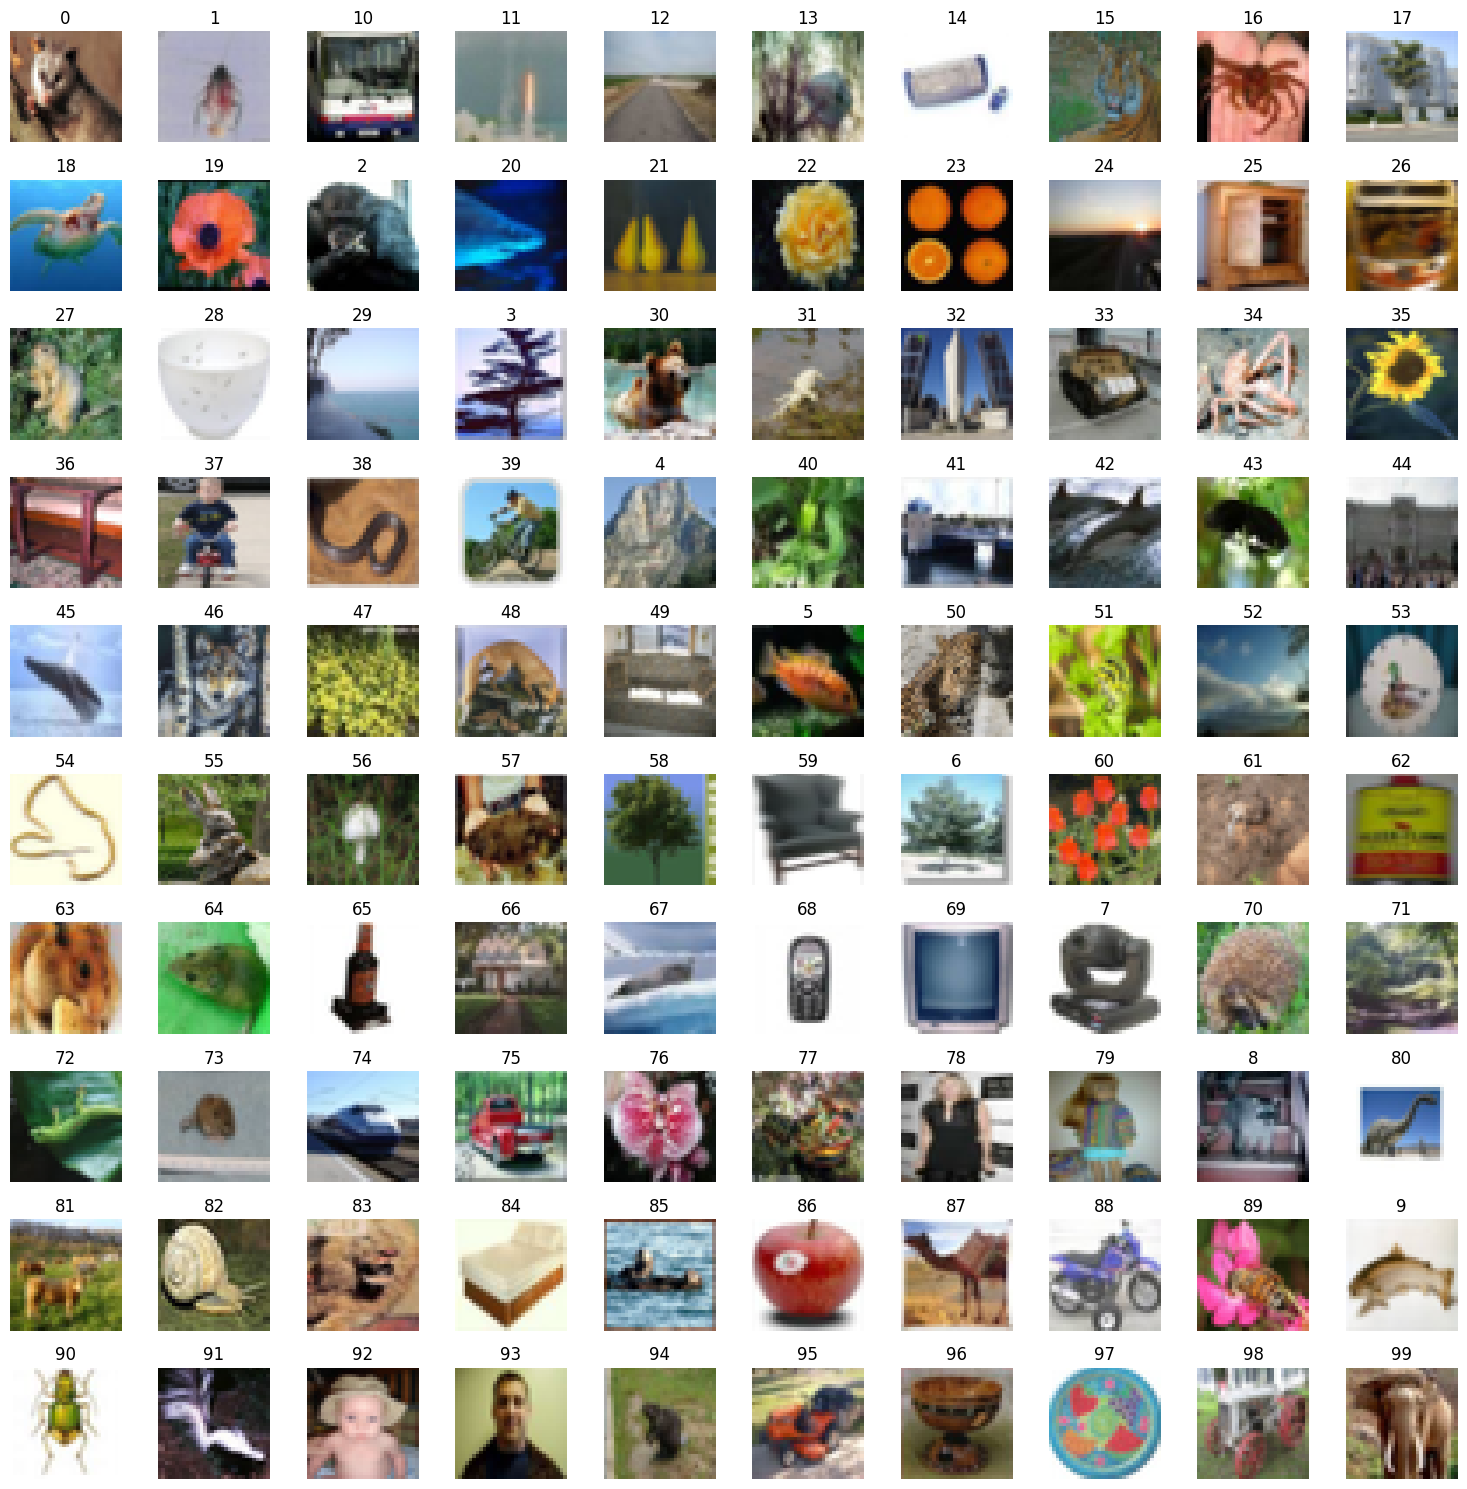

In [4]:
cl_id = {clas: None for clas in dataset.classes}

for index, (_, y_true) in enumerate(dataset):
    cl = y_true
    if cl_id[cl] is None:
        cl_id[cl] = index
        if all(v is not None for v in cl_id.values()):
            break

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.ravel()

for ax, (cl, idx) in zip(axes, cl_id.items()):
    img, _ = dataset[idx]
    img = img.permute(1, 2, 0)  # для визуализации надо (H, W, C)
    ax.imshow(img)
    ax.set_title(cl)
    ax.axis('off')
plt.tight_layout()
plt.show()

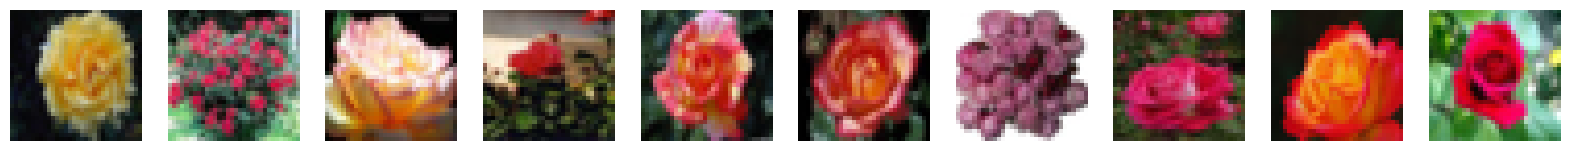

In [5]:
cl = 22
idx = []
for i, (_, y_true) in enumerate(dataset):
    if y_true == cl:
        idx.append(i)
        if len(idx) == 10:       # 10 - кол-во изображений
            break

fig, axes = plt.subplots(1, 10, figsize=(20, 20))
axes = axes.ravel()                                 # преобразовала в одномерный массив 

for ax, idx in zip(axes, idx):
    img, _ = dataset[idx]
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.show()

Выводы:
- присутствует дисбаланс классов
- мало картинок для некоторых классов (например: 32 изображений в 23 классе)
- низкое качество изображений

# 2. Аугментационный пайплайн

Тк данные достаточно маленького разрешения, я решила, что для них не нужена большая аугментация (поэтому использовала A.OneOf)

In [ ]:
train_transform = A.Compose([
    # Классические геометрические преобразования
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    
    # Ещё больше геометрических преобразований :)
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
    
    # Убираем кусочки
    A.OneOf([
        A.PixelDropout(dropout_prob=0.05, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=2, max_width=4, p=0.3)], p=0.5),
    
    # Добавляем блюр
    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5)
    ], p=0.3),
    
    # Играемся с цветами
    A.OneOf([
        A.ChannelShuffle(p=0.2),
        A.ColorJitter(p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)], p=0.5),
    
    # как же без нормализации ￣へ￣
    A.Normalize(),
    ToTensorV2()
])

# 3. Обучение моделей

##  3.1 Деление на train и val

In [2]:
dataset = datasets.ImageFolder(root="data/train", transform=None)

ind_rand = torch.randperm(len(dataset)).tolist()
shuffled_dataset = Subset(dataset, ind_rand)  

y_TRUE_sh = [y_true for _, y_true in shuffled_dataset]

In [3]:
maping = dict(zip(dataset.class_to_idx.values(), dataset.class_to_idx.keys()))

In [4]:
_, count = np.unique(y_TRUE_sh,return_counts=True)
count

array([110, 109, 134,  72, 117, 109,  50, 137, 125, 140,  47,  87, 143,
       138, 131, 115,  32, 117,  70,  44, 128, 149, 118, 119, 128,  78,
        88,  46, 118,  72, 118,  58, 125, 104, 136, 125, 149, 108,  34,
       135, 133,  95,  61,  70, 108,  45,  55, 139, 127,  56, 117,  76,
       139, 127,  80, 146, 123,  37,  80,  79,  90, 144,  69, 111,  52,
        95,  44, 137,  38,  48,  99,  94, 138,  63,  48,  44,  75,  88,
        45,  84,  48,  77, 138,  73, 150,  71, 106, 107,  96,  49,  34,
       147, 106, 150, 110, 101,  61,  40, 112,  72])

In [5]:
train_idx, val_idx = train_test_split(range(len(dataset)),test_size=0.25, stratify=y_TRUE_sh)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
print(len(train_subset), len(val_subset))

7132 2378


In [6]:
class TransformSubset(Subset):
    def __init__(self, subset, transform=None):
        super().__init__(subset.dataset, subset.indices)
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        x = np.array(x)
        if self.transform:
            x = self.transform(image=x)['image']
        return x, y

## 3.2 Mодель 1

- без transfer learning
- без навороченной аугментации 

In [11]:
train_transform_1 = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()])

val_transform_1 = A.Compose([
    A.Normalize(),
    ToTensorV2()])

train_dataset_1 = TransformSubset(train_subset, train_transform_1)
val_dataset_1 = TransformSubset(val_subset, val_transform_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=32) 

In [12]:
model_1 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2), #16
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #8
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
    nn.Flatten(),
    
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.BatchNorm1d(num_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.BatchNorm1d(num_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=100, bias=True))

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=256, out_features=100, bias=True)
)

In [14]:
# Классы распределены неравномерно, поэтому решила взвесить веса в функции потерь
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/ sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.Adam(model_1.parameters(), lr=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/25 | Train Loss: 4.5420 Train Acc: 0.0276 | Val Loss: 4.3582 Val Acc: 0.0744
Epoch 2/25 | Train Loss: 4.3095 Train Acc: 0.0653 | Val Loss: 4.1959 Val Acc: 0.0988
Epoch 3/25 | Train Loss: 4.1597 Train Acc: 0.0890 | Val Loss: 4.0790 Val Acc: 0.1262
Epoch 4/25 | Train Loss: 4.0375 Train Acc: 0.1112 | Val Loss: 3.9755 Val Acc: 0.1320
Epoch 5/25 | Train Loss: 3.9421 Train Acc: 0.1228 | Val Loss: 3.8929 Val Acc: 0.1472
Epoch 6/25 | Train Loss: 3.8437 Train Acc: 0.1360 | Val Loss: 3.7909 Val Acc: 0.1510
Epoch 7/25 | Train Loss: 3.7601 Train Acc: 0.1465 | Val Loss: 3.7125 Val Acc: 0.1699
Epoch 8/25 | Train Loss: 3.6832 Train Acc: 0.1610 | Val Loss: 3.6441 Val Acc: 0.1775
Epoch 9/25 | Train Loss: 3.6097 Train Acc: 0.1709 | Val Loss: 3.5902 Val Acc: 0.1884
Epoch 10/25 | Train Loss: 3.5383 Train Acc: 0.1819 | Val Loss: 3.5372 Val Acc: 0.1913
Epoch 11/25 | Train Loss: 3.4728 Train Acc: 0.1911 | Val Loss: 3.4730 Val Acc: 0.2031
Epoch 12/25 | Train Loss: 3.4099 Train Acc: 0.2056 | Val Loss: 

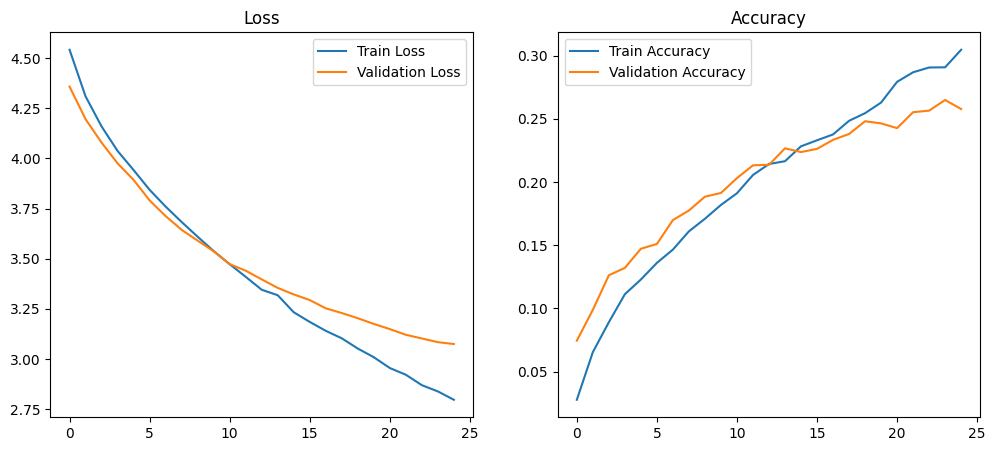

In [15]:
num_epochs = 25
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 3  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_1:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        
        optimizer.zero_grad()

        outputs = model_1(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_1)
    epoch_acc = running_corrects.double() / len(train_dataset_1)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step(epoch_loss)
    
    model_1.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_1:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_1(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_1)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_1)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_1.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## 3.3 Модель 2

- без transfer learning
- с навороченной аугментации

In [16]:
train_transform_2 = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    
    A.OneOf([
        A.PixelDropout(dropout_prob=0.05, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=4, max_width=4, p=0.3)], p=0.5),
    
    A.OneOf([
        A.ChannelShuffle(p=0.2),
        A.ColorJitter(p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5)], p=0.5),
    
    A.Normalize(),
    ToTensorV2()
])

val_transform_2 = A.Compose([
    A.Normalize(),
    ToTensorV2()])

train_dataset_2 = TransformSubset(train_subset, train_transform_2)
val_dataset_2 = TransformSubset(val_subset, val_transform_2)

train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=32) 

In [17]:
model_2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2), #16
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #8
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
    nn.Flatten(),
    
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.BatchNorm1d(num_features=512),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.BatchNorm1d(num_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=100, bias=True))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1024, out_features=512, bias=True)
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=256, out_features=100, bias=True)
)

In [18]:
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.Adam(model_2.parameters(), lr=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/25 | Train Loss: 4.5907 Train Acc: 0.0191 | Val Loss: 4.4164 Val Acc: 0.0387
Epoch 2/25 | Train Loss: 4.4316 Train Acc: 0.0393 | Val Loss: 4.2767 Val Acc: 0.0513
Epoch 3/25 | Train Loss: 4.3320 Train Acc: 0.0517 | Val Loss: 4.2007 Val Acc: 0.0820
Epoch 4/25 | Train Loss: 4.2567 Train Acc: 0.0595 | Val Loss: 4.1270 Val Acc: 0.0900
Epoch 5/25 | Train Loss: 4.2109 Train Acc: 0.0707 | Val Loss: 4.0529 Val Acc: 0.1013
Epoch 6/25 | Train Loss: 4.1525 Train Acc: 0.0774 | Val Loss: 3.9833 Val Acc: 0.1123
Epoch 7/25 | Train Loss: 4.0929 Train Acc: 0.0834 | Val Loss: 3.9188 Val Acc: 0.1152
Epoch 8/25 | Train Loss: 4.0588 Train Acc: 0.0893 | Val Loss: 3.8600 Val Acc: 0.1341
Epoch 9/25 | Train Loss: 4.0091 Train Acc: 0.0976 | Val Loss: 3.8360 Val Acc: 0.1316
Epoch 10/25 | Train Loss: 3.9790 Train Acc: 0.0979 | Val Loss: 3.7875 Val Acc: 0.1405
Epoch 11/25 | Train Loss: 3.9279 Train Acc: 0.1017 | Val Loss: 3.7381 Val Acc: 0.1581
Epoch 12/25 | Train Loss: 3.8956 Train Acc: 0.1110 | Val Loss: 

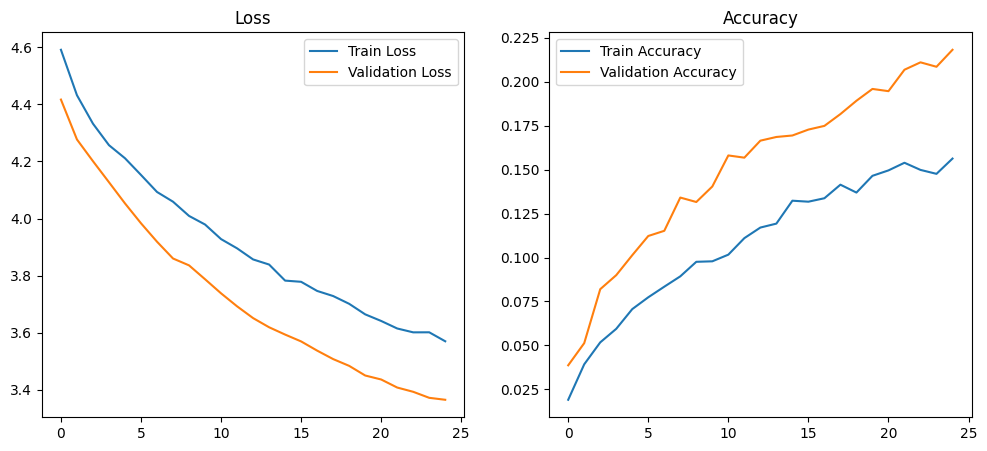

In [19]:
num_epochs = 25
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 3  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_2.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_2:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()

        outputs = model_2(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_2)
    epoch_acc = running_corrects.double() / len(train_dataset_2)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step(epoch_loss)
    
    model_2.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_2:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_2(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_2)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_2)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_2.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## 3.4 Модель 3

- с transfer learning
- без навороченной аугментации

In [13]:
train_transform_3 = A.Compose([
    A.Resize(height=256, width=256),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

val_transform_3 = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

train_dataset_3 = TransformSubset(train_subset, train_transform_3)
val_dataset_3 = TransformSubset(val_subset, val_transform_3)

train_loader_3 = DataLoader(train_dataset_3, batch_size=32, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=32) 

In [14]:
model_3 = models.wide_resnet50_2(weights="DEFAULT")

for param in model_3.parameters():
    param.requires_grad = False

head = nn.Sequential(
    nn.Linear(2048, 526),
    nn.BatchNorm1d(num_features=526),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(526, 256),
    nn.ReLU(),
    nn.Linear(256, 100)
)

model_3.fc = head

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [16]:
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.Adam(model_3.parameters(), lr=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/25 | Train Loss: 4.4855 Train Acc: 0.0559 | Val Loss: 4.2348 Val Acc: 0.1678
Epoch 2/25 | Train Loss: 3.9946 Train Acc: 0.1663 | Val Loss: 3.6228 Val Acc: 0.2464
Epoch 3/25 | Train Loss: 3.4398 Train Acc: 0.2412 | Val Loss: 3.1161 Val Acc: 0.2965
Epoch 4/25 | Train Loss: 3.0329 Train Acc: 0.2992 | Val Loss: 2.8057 Val Acc: 0.3474
Epoch 12/25 | Train Loss: 1.8535 Train Acc: 0.5087 | Val Loss: 2.1094 Val Acc: 0.4508


IOStream.flush timed out


Epoch 13/25 | Train Loss: 1.8094 Train Acc: 0.5172 | Val Loss: 2.0699 Val Acc: 0.4647
Epoch 14/25 | Train Loss: 1.7116 Train Acc: 0.5327 | Val Loss: 2.0648 Val Acc: 0.4617


IOStream.flush timed out


Epoch 15/25 | Train Loss: 1.6573 Train Acc: 0.5488 | Val Loss: 2.0532 Val Acc: 0.4634
Epoch 16/25 | Train Loss: 1.5881 Train Acc: 0.5711 | Val Loss: 2.0520 Val Acc: 0.4664
Epoch 17/25 | Train Loss: 1.5781 Train Acc: 0.5704 | Val Loss: 2.0349 Val Acc: 0.4651
Epoch 18/25 | Train Loss: 1.5069 Train Acc: 0.5808 | Val Loss: 2.0477 Val Acc: 0.4668
EarlyStopping counter: 1 out of 3
Epoch 19/25 | Train Loss: 1.4768 Train Acc: 0.5907 | Val Loss: 2.0191 Val Acc: 0.4722
Epoch 20/25 | Train Loss: 1.4307 Train Acc: 0.5899 | Val Loss: 2.0171 Val Acc: 0.4836


IOStream.flush timed out


Epoch 21/25 | Train Loss: 1.4077 Train Acc: 0.6059 | Val Loss: 2.0210 Val Acc: 0.4882
EarlyStopping counter: 1 out of 3
Epoch 22/25 | Train Loss: 1.3372 Train Acc: 0.6200 | Val Loss: 2.0168 Val Acc: 0.4907
EarlyStopping counter: 2 out of 3
Epoch 23/25 | Train Loss: 1.3468 Train Acc: 0.6112 | Val Loss: 2.0483 Val Acc: 0.4638
EarlyStopping counter: 3 out of 3
Early stopping triggered!


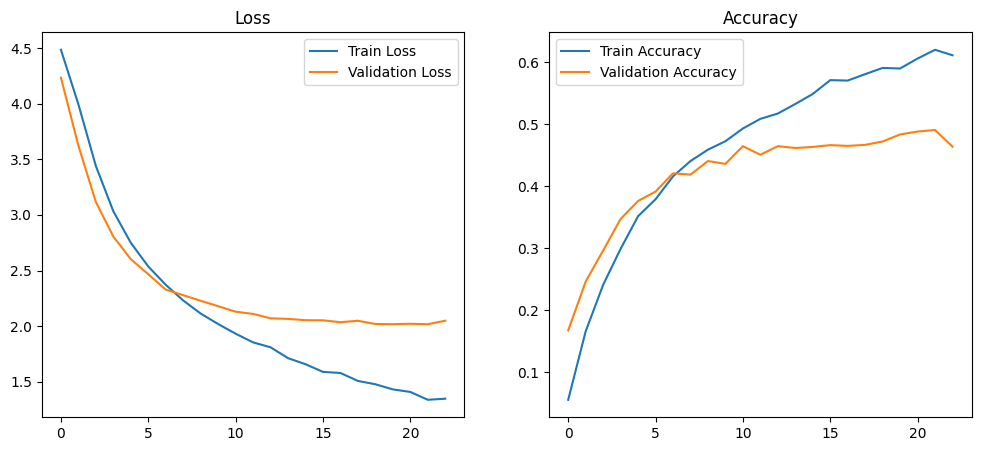

In [ ]:
num_epochs = 25
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 3  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_3.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_3:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()

        outputs = model_3(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_3)
    epoch_acc = running_corrects.double() / len(train_dataset_3)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step(epoch_loss)
    
    model_3.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_3:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_3(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_3)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_3)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_3.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## 3.5 Модель 4 (Кагл: 0.67)

- c transfer learning
- с навороченной аугментации

In [23]:
train_transform_4 = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    
    A.OneOf([
        A.PixelDropout(dropout_prob=0.05, p=0.4),
        A.CoarseDropout(max_holes=8, max_height=3, max_width=3, fill_value=0, p=0.3),
        A.GridDropout(ratio=0.05, p=0.2)
    ], p=0.5),
    
    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5)
    ], p=0.3),
    
    A.GaussNoise(var_limit=(5, 20), p=0.4),
    
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3, border_mode=cv2.BORDER_REFLECT),
    
    A.OneOf([
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
    ], p=0.3),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform_4 = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset_4 = TransformSubset(train_subset, train_transform_4)
val_dataset_4 = TransformSubset(val_subset, val_transform_4)

train_loader_4 = DataLoader(train_dataset_4, batch_size=32, shuffle=True)
val_loader_4 = DataLoader(val_dataset_4, batch_size=32)

In [24]:
model_4 = models.wide_resnet50_2(weights="DEFAULT")

for param in model_4.parameters():
    param.requires_grad = False
for param in model_4.layer4.parameters():
    param.requires_grad = True

head = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 100)
)

model_4.fc = head

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [26]:
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.AdamW(model_4.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=32,epochs=15)

Epoch 1/30 | Train Loss: 4.5779 Train Acc: 0.0280 | Val Loss: 4.3414 Val Acc: 0.1640
Epoch 2/30 | Train Loss: 4.2916 Train Acc: 0.0998 | Val Loss: 3.9182 Val Acc: 0.2965
Epoch 3/30 | Train Loss: 3.9415 Train Acc: 0.1747 | Val Loss: 3.4268 Val Acc: 0.3293
Epoch 4/30 | Train Loss: 3.5872 Train Acc: 0.2468 | Val Loss: 3.0581 Val Acc: 0.3663
Epoch 5/30 | Train Loss: 3.2999 Train Acc: 0.2974 | Val Loss: 2.7422 Val Acc: 0.4214
Epoch 6/30 | Train Loss: 3.0404 Train Acc: 0.3423 | Val Loss: 2.4865 Val Acc: 0.4840
Epoch 7/30 | Train Loss: 2.7760 Train Acc: 0.3961 | Val Loss: 2.2443 Val Acc: 0.5185
Epoch 8/30 | Train Loss: 2.5549 Train Acc: 0.4483 | Val Loss: 2.0210 Val Acc: 0.5622
Epoch 9/30 | Train Loss: 2.3679 Train Acc: 0.4743 | Val Loss: 1.8471 Val Acc: 0.5955
Epoch 10/30 | Train Loss: 2.1684 Train Acc: 0.5165 | Val Loss: 1.6684 Val Acc: 0.6152
Epoch 11/30 | Train Loss: 1.9932 Train Acc: 0.5436 | Val Loss: 1.5712 Val Acc: 0.6371
Epoch 12/30 | Train Loss: 1.8614 Train Acc: 0.5756 | Val Loss: 

IOStream.flush timed out


Epoch 20/30 | Train Loss: 1.0612 Train Acc: 0.7344 | Val Loss: 1.2397 Val Acc: 0.6930
Epoch 21/30 | Train Loss: 0.9992 Train Acc: 0.7414 | Val Loss: 1.2914 Val Acc: 0.6833
EarlyStopping counter: 1 out of 4
Epoch 22/30 | Train Loss: 0.9507 Train Acc: 0.7602 | Val Loss: 1.2691 Val Acc: 0.6876
EarlyStopping counter: 2 out of 4
Epoch 23/30 | Train Loss: 0.8896 Train Acc: 0.7681 | Val Loss: 1.2882 Val Acc: 0.6901
EarlyStopping counter: 3 out of 4
Epoch 24/30 | Train Loss: 0.8290 Train Acc: 0.7834 | Val Loss: 1.2793 Val Acc: 0.6913
EarlyStopping counter: 4 out of 4
Early stopping triggered!


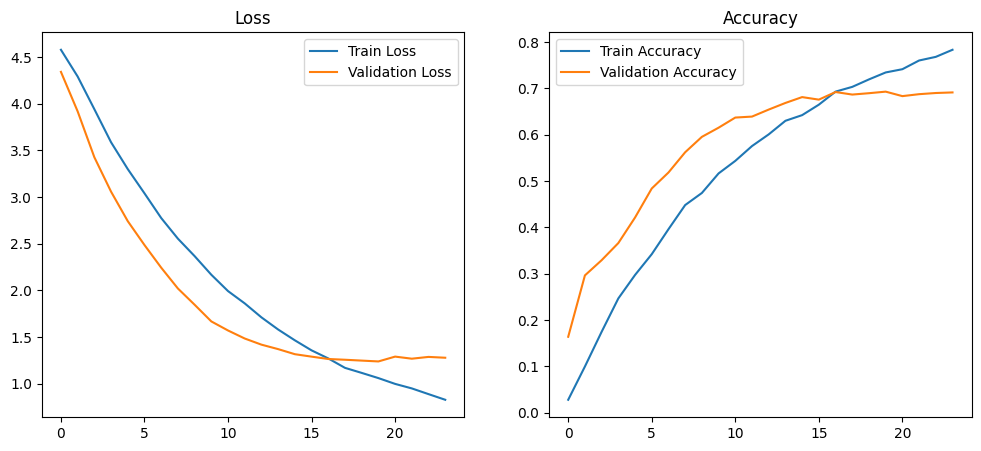

In [27]:
num_epochs = 30
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 4  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_4.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_4:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()

        outputs = model_4(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_4)
    epoch_acc = running_corrects.double() / len(train_dataset_4)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step()
    
    model_4.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_4:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_4(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_4)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_4)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_4.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

Эта модель на кагле выбила 0.67

# Для Кагля

## Деление

In [ ]:
dataset = datasets.ImageFolder(root="data/train", transform=None)

ind_rand = torch.randperm(len(dataset)).tolist()
shuffled_dataset = Subset(dataset, ind_rand)  

y_TRUE_sh = [y_true for _, y_true in shuffled_dataset]

maping = dict(zip(dataset.class_to_idx.values(), dataset.class_to_idx.keys()))

_, count = np.unique(y_TRUE_sh,return_counts=True)
count

In [ ]:
train_idx, val_idx = train_test_split(range(len(dataset)),test_size=0.25, stratify=y_TRUE_sh)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
print(len(train_subset), len(val_subset))

In [ ]:
class TransformSubset(Subset):
    def __init__(self, subset, transform=None):
        super().__init__(subset.dataset, subset.indices)
        self.transform = transform
        
    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        x = np.array(x)
        if self.transform:
            x = self.transform(image=x)['image']
        return x, y

## Модель 5

- Более сожная аугументация

In [92]:
# поменяла трансформер, сделала его более разнообразным
train_transform_5 = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),   

    A.PixelDropout(dropout_prob=0.05, p=0.4),
    A.MedianBlur(blur_limit=3, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    
    A.GaussNoise(var_limit=(5, 20), p=0.2),
    
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ToTensorV2(),
])

val_transform_5 = A.Compose([
    A.Resize(height=224, width=224,interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [93]:
train_dataset_5 = TransformSubset(train_subset, train_transform_5)
val_dataset_5 = TransformSubset(val_subset, val_transform_5)

In [94]:
train_loader_5 = DataLoader(train_dataset_5, batch_size=32, shuffle=True)
val_loader_5 = DataLoader(val_dataset_5, batch_size=32)

In [95]:
model_5 = models.wide_resnet50_2(weights="DEFAULT")

for param in model_5.parameters():
    param.requires_grad = False
for param in model_5.layer4.parameters():
    param.requires_grad = True

head = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 100)
)

model_5.fc = head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [96]:
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.AdamW(model_5.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=32,epochs=30)

Epoch 1/30 | Train Loss: 4.7535 Train Acc: 0.0140 | Val Loss: 4.4551 Val Acc: 0.0774
Epoch 2/30 | Train Loss: 4.5794 Train Acc: 0.0278 | Val Loss: 4.2355 Val Acc: 0.2300
Epoch 3/30 | Train Loss: 4.3710 Train Acc: 0.0572 | Val Loss: 3.9543 Val Acc: 0.3175
Epoch 4/30 | Train Loss: 4.1443 Train Acc: 0.0970 | Val Loss: 3.6595 Val Acc: 0.3595
Epoch 5/30 | Train Loss: 3.9364 Train Acc: 0.1360 | Val Loss: 3.3391 Val Acc: 0.3713
Epoch 6/30 | Train Loss: 3.7398 Train Acc: 0.1702 | Val Loss: 3.1531 Val Acc: 0.3839
Epoch 7/30 | Train Loss: 3.5391 Train Acc: 0.2120 | Val Loss: 2.8969 Val Acc: 0.4012
Epoch 8/30 | Train Loss: 3.3621 Train Acc: 0.2452 | Val Loss: 2.7441 Val Acc: 0.4310
Epoch 9/30 | Train Loss: 3.1870 Train Acc: 0.2824 | Val Loss: 2.5747 Val Acc: 0.4609
Epoch 10/30 | Train Loss: 3.0388 Train Acc: 0.3153 | Val Loss: 2.4174 Val Acc: 0.4903
Epoch 11/30 | Train Loss: 2.8794 Train Acc: 0.3403 | Val Loss: 2.2378 Val Acc: 0.5181
Epoch 12/30 | Train Loss: 2.7460 Train Acc: 0.3734 | Val Loss: 

IOStream.flush timed out


Epoch 17/30 | Train Loss: 2.1321 Train Acc: 0.4954 | Val Loss: 1.6349 Val Acc: 0.6169
Epoch 18/30 | Train Loss: 2.0380 Train Acc: 0.5212 | Val Loss: 1.5840 Val Acc: 0.6266
Epoch 19/30 | Train Loss: 1.9406 Train Acc: 0.5458 | Val Loss: 1.5205 Val Acc: 0.6362
Epoch 20/30 | Train Loss: 1.8417 Train Acc: 0.5624 | Val Loss: 1.4789 Val Acc: 0.6514


IOStream.flush timed out


Epoch 21/30 | Train Loss: 1.7283 Train Acc: 0.5881 | Val Loss: 1.4214 Val Acc: 0.6611
Epoch 22/30 | Train Loss: 1.6829 Train Acc: 0.5979 | Val Loss: 1.3991 Val Acc: 0.6644


IOStream.flush timed out


Epoch 23/30 | Train Loss: 1.5810 Train Acc: 0.6251 | Val Loss: 1.3592 Val Acc: 0.6770
Epoch 24/30 | Train Loss: 1.5165 Train Acc: 0.6311 | Val Loss: 1.3272 Val Acc: 0.6817
Epoch 25/30 | Train Loss: 1.4462 Train Acc: 0.6475 | Val Loss: 1.3128 Val Acc: 0.6863
Epoch 26/30 | Train Loss: 1.3731 Train Acc: 0.6666 | Val Loss: 1.2735 Val Acc: 0.6892
Epoch 27/30 | Train Loss: 1.3303 Train Acc: 0.6859 | Val Loss: 1.2744 Val Acc: 0.6922
EarlyStopping counter: 1 out of 4
Epoch 28/30 | Train Loss: 1.2587 Train Acc: 0.6918 | Val Loss: 1.2786 Val Acc: 0.6943
EarlyStopping counter: 2 out of 4
Epoch 29/30 | Train Loss: 1.2179 Train Acc: 0.6971 | Val Loss: 1.2647 Val Acc: 0.6901
Epoch 30/30 | Train Loss: 1.1487 Train Acc: 0.7084 | Val Loss: 1.2778 Val Acc: 0.6905
EarlyStopping counter: 1 out of 4


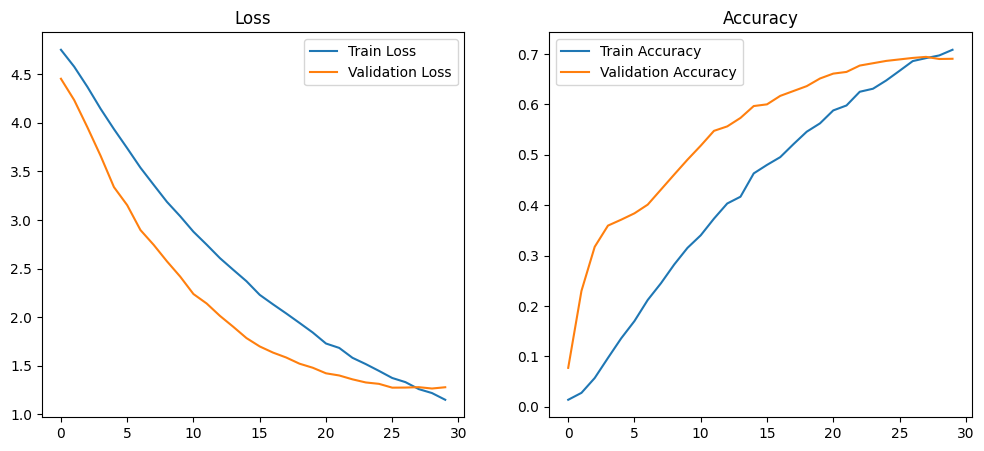

In [ ]:
num_epochs = 30
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 4  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_5.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_5:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()

        outputs = model_5(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_5)
    epoch_acc = running_corrects.double() / len(train_dataset_5)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step()
    
    model_5.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_5:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_5(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_5)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_5)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_5.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Модель 7 (Кагл: 0.72)

In [98]:
train_transform_7 = A.Compose([
    A.Resize(height=152, width=152, interpolation=cv2.INTER_CUBIC),
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    
    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5)
    ], p=0.3),
    
    A.OneOf([
        A.PixelDropout(dropout_prob=0.05, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=3, max_width=3, fill_value=0, p=0.3),
        A.GridDropout(ratio=0.05, p=0.2)
    ], p=0.5),
    
    A.GaussNoise(var_limit=(5, 20), p=0.4),
    
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3, border_mode=cv2.BORDER_REFLECT),
    
    A.OneOf([
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
    ], p=0.3),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform_7 = A.Compose([
    A.Resize(height=152, width=152, interpolation=cv2.INTER_CUBIC),
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset_7 = TransformSubset(train_subset, train_transform_7)
val_dataset_7 = TransformSubset(val_subset, val_transform_7)

train_loader_7 = DataLoader(train_dataset_7, batch_size=32, shuffle=True)
val_loader_7 = DataLoader(val_dataset_7, batch_size=32)

In [99]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions.beta import Beta

def mixup(inputs, labels, alpha=1.0):    # попробовала использовать mixup
    lam = np.random.beta(alpha, alpha)
    
    batch_size = inputs.size()[0]
    index = torch.randperm(batch_size).to(inputs.device)

    inputs = lam * inputs + (1 - lam) * inputs[index, :]
    labels1 = labels
    labels2 = labels[index]
    
    return inputs, (labels1, labels2, lam)

In [100]:
model_7 = models.wide_resnet50_2(weights="DEFAULT")

for param in model_7.parameters():
    param.requires_grad = False
    
for param in model_7.layer3.parameters():
    param.requires_grad = True
for param in model_7.layer4.parameters():
    param.requires_grad = True

head = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 100)
)

model_7.fc = head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_7.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [102]:
#weights = 1. / torch.tensor(count, dtype=torch.float32)
#weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss() #weight=weights.to(device)
optimizer = optim.AdamW(model_7.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_7),epochs=30)

Epoch 1/30 | Train Loss: 4.5714 Train Acc: 0.0239 | Val Loss: 4.3358 Val Acc: 0.1518
Epoch 2/30 | Train Loss: 4.2967 Train Acc: 0.0870 | Val Loss: 3.8402 Val Acc: 0.2885
Epoch 3/30 | Train Loss: 4.0038 Train Acc: 0.1567 | Val Loss: 3.4020 Val Acc: 0.3726
Epoch 4/30 | Train Loss: 3.6715 Train Acc: 0.2373 | Val Loss: 2.9877 Val Acc: 0.4327
Epoch 5/30 | Train Loss: 3.4374 Train Acc: 0.2868 | Val Loss: 2.6277 Val Acc: 0.4861
Epoch 6/30 | Train Loss: 3.2709 Train Acc: 0.3189 | Val Loss: 2.4084 Val Acc: 0.5114
Epoch 7/30 | Train Loss: 3.0298 Train Acc: 0.3713 | Val Loss: 2.1553 Val Acc: 0.5639
Epoch 8/30 | Train Loss: 2.9323 Train Acc: 0.3945 | Val Loss: 1.9784 Val Acc: 0.5774
Epoch 9/30 | Train Loss: 2.7625 Train Acc: 0.4224 | Val Loss: 1.7825 Val Acc: 0.6186
Epoch 10/30 | Train Loss: 2.6547 Train Acc: 0.4485 | Val Loss: 1.6663 Val Acc: 0.6426
Epoch 11/30 | Train Loss: 2.5665 Train Acc: 0.4685 | Val Loss: 1.5325 Val Acc: 0.6636
Epoch 12/30 | Train Loss: 2.3875 Train Acc: 0.5056 | Val Loss: 

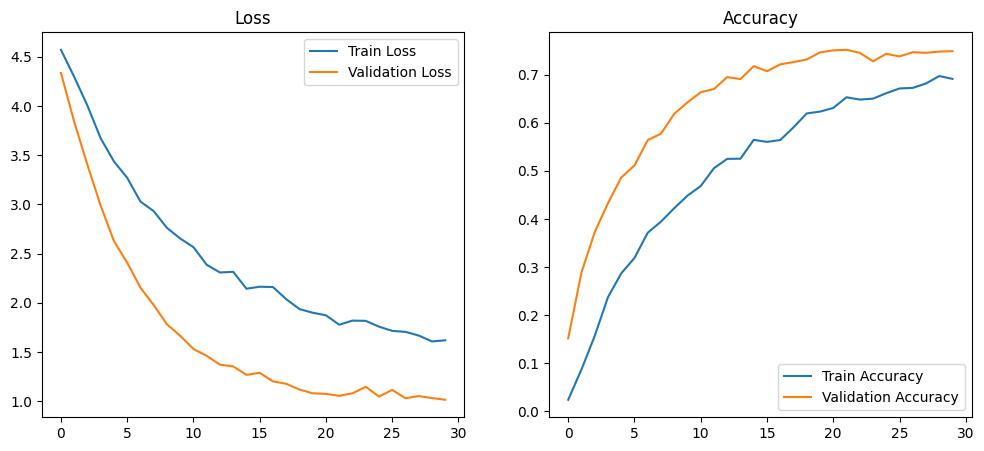

In [103]:
num_epochs = 30
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 4  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_7.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_7:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        inputs, (labels1, labels2, lam) = mixup(inputs, labels, alpha=0.5)
        
        optimizer.zero_grad()

        outputs = model_7(inputs)
        loss = lam * criterion(outputs, labels1) + (1 - lam) * criterion(outputs, labels2)
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels1.data) * lam + torch.sum(preds == labels2.data) * (1 - lam)
    
    epoch_loss = running_loss / len(train_dataset_7)
    epoch_acc = running_corrects.double() / len(train_dataset_7)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step()
    
    model_7.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_7:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_7(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_7)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_7)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_7.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Модель 6 (Кагл: 0.71)

In [62]:
train_transform_6 = A.Compose([
    A.Resize(height=152, width=152, interpolation=cv2.INTER_CUBIC),
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    
    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.5),
        A.GaussianBlur(blur_limit=(3, 5), p=0.5)
    ], p=0.3),
    
    A.OneOf([
        A.PixelDropout(dropout_prob=0.05, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=3, max_width=3, fill_value=0, p=0.3),
        A.GridDropout(ratio=0.05, p=0.2)
    ], p=0.5),
    
    A.GaussNoise(var_limit=(5, 20), p=0.4),
    
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3, border_mode=cv2.BORDER_REFLECT),
    
    A.OneOf([
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5)
    ], p=0.3),
    
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform_6 = A.Compose([
    A.Resize(height=152, width=152, interpolation=cv2.INTER_CUBIC),
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_dataset_6 = TransformSubset(train_subset, train_transform_6)
val_dataset_6 = TransformSubset(val_subset, val_transform_6)

train_loader_6 = DataLoader(train_dataset_6, batch_size=32, shuffle=True)
val_loader_6 = DataLoader(val_dataset_6, batch_size=32)

In [63]:
model_6 = models.wide_resnet50_2(weights="DEFAULT")

for param in model_6.parameters():
    param.requires_grad = False
    
for param in model_6.layer3.parameters():
    param.requires_grad = True
for param in model_6.layer4.parameters():
    param.requires_grad = True

head = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 100)
)

model_6.fc = head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_6.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [64]:
weights = 1. / torch.tensor(count, dtype=torch.float32)
weights = weights/sum(weights)
criterion = nn.CrossEntropyLoss(weight=weights.to(device)) #weight=weights.to(device)
optimizer = optim.AdamW(model_6.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_6),epochs=30)

Epoch 1/30 | Train Loss: 4.5756 Train Acc: 0.0275 | Val Loss: 4.3273 Val Acc: 0.1859
Epoch 2/30 | Train Loss: 4.2524 Train Acc: 0.1102 | Val Loss: 3.8804 Val Acc: 0.3246
Epoch 3/30 | Train Loss: 3.8255 Train Acc: 0.2225 | Val Loss: 3.3450 Val Acc: 0.4020
Epoch 4/30 | Train Loss: 3.4245 Train Acc: 0.3047 | Val Loss: 2.9068 Val Acc: 0.4731
Epoch 5/30 | Train Loss: 3.0509 Train Acc: 0.3815 | Val Loss: 2.5388 Val Acc: 0.5282
Epoch 6/30 | Train Loss: 2.6902 Train Acc: 0.4600 | Val Loss: 2.2350 Val Acc: 0.5778
Epoch 7/30 | Train Loss: 2.3866 Train Acc: 0.5195 | Val Loss: 1.9521 Val Acc: 0.6287
Epoch 8/30 | Train Loss: 2.0921 Train Acc: 0.5759 | Val Loss: 1.7252 Val Acc: 0.6560


IOStream.flush timed out


Epoch 9/30 | Train Loss: 1.8450 Train Acc: 0.6244 | Val Loss: 1.5298 Val Acc: 0.6817
Epoch 10/30 | Train Loss: 1.6240 Train Acc: 0.6632 | Val Loss: 1.3580 Val Acc: 0.7073


IOStream.flush timed out


Epoch 11/30 | Train Loss: 1.4363 Train Acc: 0.6970 | Val Loss: 1.2950 Val Acc: 0.7103
Epoch 12/30 | Train Loss: 1.2744 Train Acc: 0.7151 | Val Loss: 1.1935 Val Acc: 0.7237


IOStream.flush timed out


Epoch 13/30 | Train Loss: 1.1290 Train Acc: 0.7552 | Val Loss: 1.1755 Val Acc: 0.7229
Epoch 14/30 | Train Loss: 1.0081 Train Acc: 0.7751 | Val Loss: 1.1111 Val Acc: 0.7342
Epoch 15/30 | Train Loss: 0.8818 Train Acc: 0.8003 | Val Loss: 1.0769 Val Acc: 0.7464
Epoch 16/30 | Train Loss: 0.7996 Train Acc: 0.8167 | Val Loss: 1.0568 Val Acc: 0.7418
Epoch 17/30 | Train Loss: 0.6996 Train Acc: 0.8383 | Val Loss: 1.0676 Val Acc: 0.7477
EarlyStopping counter: 1 out of 4
Epoch 18/30 | Train Loss: 0.6260 Train Acc: 0.8571 | Val Loss: 1.0471 Val Acc: 0.7540


IOStream.flush timed out


Epoch 19/30 | Train Loss: 0.5646 Train Acc: 0.8720 | Val Loss: 1.0290 Val Acc: 0.7620
Epoch 20/30 | Train Loss: 0.5303 Train Acc: 0.8808 | Val Loss: 1.0233 Val Acc: 0.7511
Epoch 21/30 | Train Loss: 0.4856 Train Acc: 0.8884 | Val Loss: 1.0445 Val Acc: 0.7523
EarlyStopping counter: 1 out of 4
Epoch 22/30 | Train Loss: 0.4353 Train Acc: 0.8955 | Val Loss: 1.0897 Val Acc: 0.7460
EarlyStopping counter: 2 out of 4
Epoch 23/30 | Train Loss: 0.3849 Train Acc: 0.9063 | Val Loss: 1.1220 Val Acc: 0.7426
EarlyStopping counter: 3 out of 4
Epoch 24/30 | Train Loss: 0.3774 Train Acc: 0.9108 | Val Loss: 1.1211 Val Acc: 0.7397
EarlyStopping counter: 4 out of 4
Early stopping triggered!


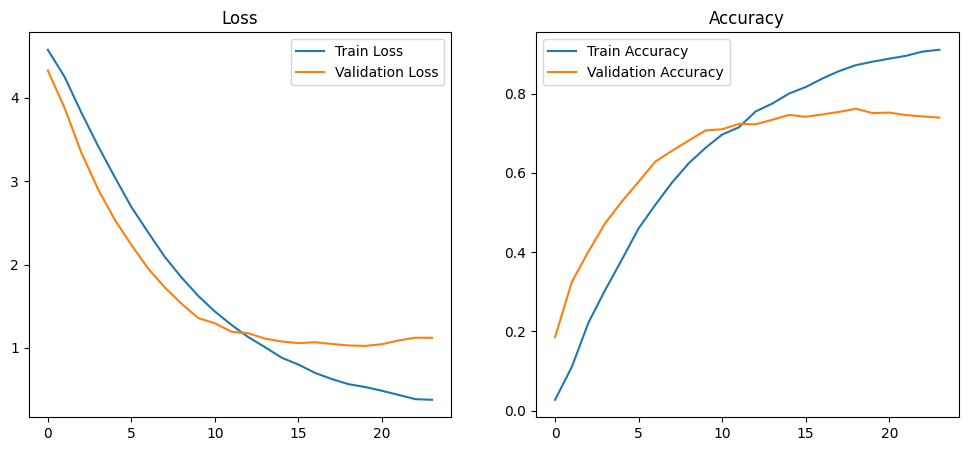

In [65]:
num_epochs = 30
train_losses=[]
train_accs=[]
val_losses = []
val_accs =[]

patience = 4  
min_delta = 0.001
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model_6.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader_6:
        inputs = inputs.to(device)
        labels = labels.to(device).long()
        optimizer.zero_grad()

        outputs = model_6(inputs)
        loss = criterion(outputs, labels) 
        loss.backward()    
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset_6)
    epoch_acc = running_corrects.double() / len(train_dataset_6)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    scheduler.step()
    
    model_6.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader_6:
            inputs = inputs.to(device)
            labels = labels.to(device).long() 
            
            outputs = model_6(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)
    val_epoch_loss = val_running_loss / len(val_dataset_6)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset_6)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} | '
          f'Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} | '
          f'Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.4f}')
    
    if val_epoch_loss + min_delta < best_val_loss:
        best_val_loss = val_epoch_loss
        counter = 0
        torch.save(model_6.state_dict(), 'best_model.pth')
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            print('Early stopping triggered!')
            break
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Выгрузка

In [110]:
class TestDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)["image"]
        
        return image, self.image_files[idx]


#model.load_state_dict(torch.load('best_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_7.to(device)

model_7.eval()

test_dataset = TestDataset(folder_path="data/test", transform=val_transform_6)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

results_ind = []
results_pred= []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model_7(images)
        _, predicted = torch.max(outputs, 1)
        ind = int(filenames[0].replace('.png', ''))
        results_ind.append(ind)
        results_pred.append(predicted.item())

In [113]:
new_pred = [maping.get(item, item) for item in results_pred]
df = pd.DataFrame({
    'id': results_ind,  
    'target': new_pred
})

df_sorted = df.sort_values('id')
df_sorted.to_csv('results.csv', index=False)

# 4. Генерация 

Я попыталась  сделать генератор, но он очень плохого качества

In [47]:
train_transform_g = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()])

val_transform_g = A.Compose([
    A.Normalize(),
    ToTensorV2()])

train_dataset_g = TransformSubset(train_subset, train_transform_g)
val_dataset_g = TransformSubset(val_subset, val_transform_g)

train_loader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True)
val_loader_g = DataLoader(val_dataset_g, batch_size=32) 

In [48]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=100, img_channels=3, embed_dim=100):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        
        self.label_embedding = nn.Sequential(
                nn.Embedding(num_classes, embed_dim),
                nn.Linear(embed_dim, embed_dim),
                nn.LeakyReLU())
        
        self.projection = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 512 * 4**2),
            nn.BatchNorm1d(512 * 4**2),
            nn.LeakyReLU(),
            nn.Unflatten(1, (512, 4, 4)))
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, img_channels, 3, 1, 1, bias=False),
            nn.Tanh())

    def forward(self, noise, labels):
        label_embed = self.label_embedding(labels)
        x = torch.cat((noise, label_embed), dim=1)
        x = self.projection(x)
        return self.upsample(x)


class Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_channels=3, embed_dim=100):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.LeakyReLU()
        )
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(),
            
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.LeakyReLU(),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1 + embed_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):    
        features = self.feature_extractor(img)
        features = features.view(features.size(0), -1)    
        label_embed = self.label_embedding(labels)
        x = torch.cat((features, label_embed), dim=1)
        return self.classifier(x)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

Discriminator(
  (label_embedding): Sequential(
    (0): Embedding(100, 100)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): AdaptiveAvgPool2d(outpu

In [50]:
opt_g = torch.optim.Adam(generator.parameters(), lr=2e-3)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=2e-3)
criterion = nn.BCELoss()

In [51]:
for epoch in range(100):
    generator.train()
    discriminator.train()
    for real_imgs, real_labels in train_loader_g:
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_imgs.size(0)
        
        opt_d.zero_grad()
        
        real_pred = discriminator(real_imgs, real_labels)
        loss_real = criterion(real_pred, torch.ones(batch_size, 1).to(device))
        
        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 100, (batch_size,)).to(device)
        fake_imgs = generator(z, fake_labels)
        
        fake_pred = discriminator(fake_imgs.detach(), fake_labels)
        loss_fake = criterion(fake_pred, torch.zeros(batch_size, 1).to(device))
        
        loss_d = loss_real + loss_fake
        loss_d.backward()
        opt_d.step()
        

        opt_g.zero_grad()
            
        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, 100, (batch_size,)).to(device)
        fake_imgs = generator(z, fake_labels)
            
        fake_pred = discriminator(fake_imgs, fake_labels)
        loss_g = criterion(fake_pred, torch.ones(batch_size, 1).to(device))
        loss_g.backward()
        opt_g.step()
    
    print(f'Epoch {epoch + 1}/100 | '
          f'Generator Loss: {loss_g:.4f} | '
          f'Discriminator Loss: {loss_d:.4f} ')

Epoch 1/100 | Generator Loss: 9.6497 | Discriminator Loss: 0.0054 
Epoch 2/100 | Generator Loss: 9.5942 | Discriminator Loss: 0.0127 
Epoch 3/100 | Generator Loss: 8.1285 | Discriminator Loss: 0.3188 
Epoch 4/100 | Generator Loss: 6.9372 | Discriminator Loss: 0.0218 
Epoch 5/100 | Generator Loss: 6.2727 | Discriminator Loss: 0.1071 
Epoch 6/100 | Generator Loss: 7.3527 | Discriminator Loss: 0.2703 
Epoch 7/100 | Generator Loss: 7.5271 | Discriminator Loss: 0.2240 
Epoch 8/100 | Generator Loss: 4.1887 | Discriminator Loss: 0.1739 
Epoch 9/100 | Generator Loss: 4.2371 | Discriminator Loss: 0.0826 
Epoch 10/100 | Generator Loss: 8.5690 | Discriminator Loss: 0.0139 
Epoch 11/100 | Generator Loss: 4.5828 | Discriminator Loss: 0.3131 
Epoch 12/100 | Generator Loss: 8.5886 | Discriminator Loss: 0.4584 
Epoch 13/100 | Generator Loss: 7.9049 | Discriminator Loss: 0.1040 
Epoch 14/100 | Generator Loss: 4.4720 | Discriminator Loss: 0.1215 
Epoch 15/100 | Generator Loss: 7.3828 | Discriminator Los

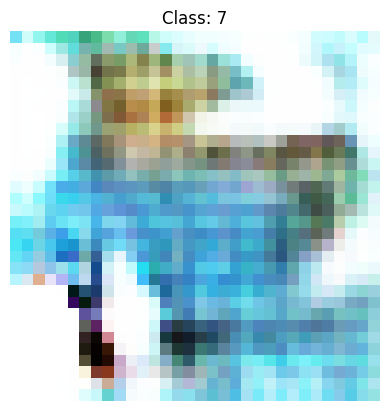

In [58]:
z = torch.randn(1, 100).to(device)
label = torch.tensor([7]).to(device)

generator.eval()  
with torch.no_grad():
    fake_img = generator(z, label)

# Визуализация
img = fake_img.squeeze().permute(1, 2, 0).cpu().numpy()
img = (img + 1) / 2
plt.imshow(img)
plt.title(f"Class: {label.item()}")
plt.axis('off')
plt.show()